In [3]:
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from torch.utils.data import TensorDataset, DataLoader 
import torchvision.transforms as transforms
import time, copy
import torchvision

          x         y
0 -1.000000  0.985444
1 -0.998666  0.853121
2 -0.997332  0.615542
3 -0.995997  0.460276
4 -0.994663  0.708375


<AxesSubplot:xlabel='x', ylabel='y'>

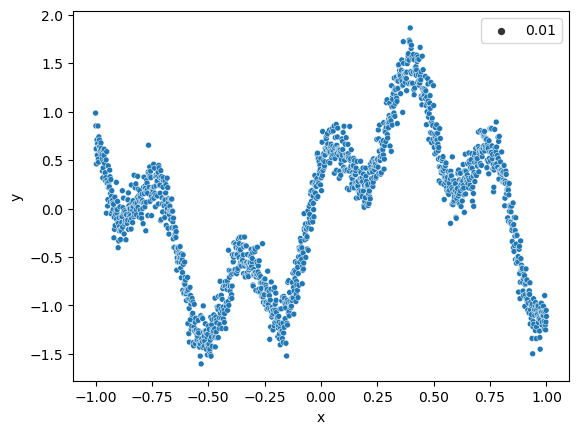

In [42]:
size = 1500
x = np.linspace(-1.0, 1.0, size)
# Y_data = 0.5*(x)**3.0
Y_data = np.sin(4*x)+ np.sin(17*x+1.1)*0.5
Y_data += np.random.normal(size=size)*0.14

data = zip(x, Y_data)
df = pd.DataFrame(data=data, columns=['x','y'])

print(df.head())
sns.scatterplot(data=df, x='x', y='y', size=0.01)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# feature_columns:  List(String)    - list of column names to be used as features (X)
# label_column:     String          - column to be used as target (Y)
# ct:               ColumnTransformer
def train_test_val_split(df, feature_columns, label_column, ct):
    
    # Primero, realizar una división 80/20 en entrenamiento y prueba
    seed = 42
    initial_train_split = df.sample(frac=.8, random_state = seed)
    test = df.drop(initial_train_split.index)   # remover todo este subset del dataset original
    # test = 20%
    # init = 80%

    # A continuación, realizar una división 75/25 entre entrenamiento y validación
    train = initial_train_split.sample(frac=.75, random_state = seed)
    val = initial_train_split.drop(train.index)
    # val   = 25%
    # train = 75%

    # Dividir todos los subconjuntos en atributos y etiquetas (x e y)
    train_x = train[feature_columns]
    # No transformaremos las etiquetas para que vayan directamente a los tensores torch
    train_y = torch.from_numpy(train[label_column].values)

    val_x = val[feature_columns]
    val_y = torch.from_numpy(val[label_column].values)

    test_x = test[feature_columns]
    test_y = torch.from_numpy(test[label_column].values)

    # Ajustar ColumnTransfer al conjunto de entrenamiento
    ct.fit(train_x)

    # Realizar la estandarización con cada uno de los conjuntos de datos x
    train_x = ct.transform(train_x)
    val_x = ct.transform(val_x)
    test_x = ct.transform(test_x)

    # Convertir los conjuntos de datos en tensores Torch
    train_x = torch.from_numpy(train_x).float()
    val_x = torch.from_numpy(val_x).float()
    test_x = torch.from_numpy(test_x).float()

    # Crear los conjuntos de datos de pares input-etiqueta para que PyTorch los consuma
    train_dataset = TensorDataset(train_x, train_y)
    test_dataset = TensorDataset(test_x, test_y)
    val_dataset = TensorDataset(val_x, val_y)
    return train_dataset, test_dataset, val_dataset


<AxesSubplot:>

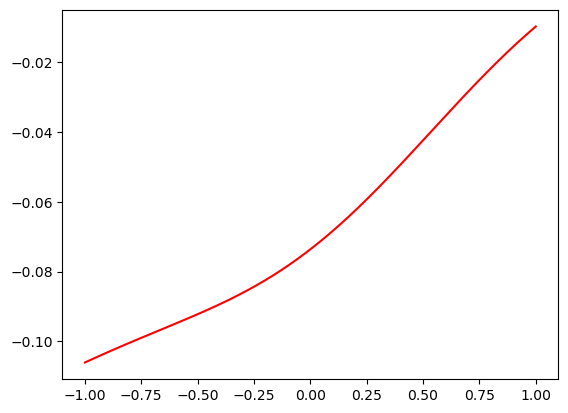

In [155]:
class LinearRegressor_1D(nn.Module):
    def __init__(self):
        super(LinearRegressor_1D, self).__init__()
        self.dropout = nn.Dropout(p=0.25)
        self.model = nn.Sequential(
            nn.Linear(1,256),
            nn.Tanh(),
            nn.Linear(256,128),
            nn.Tanh(),
            nn.Linear(128,64),
            nn.Tanh(),
            nn.Linear(64,1),

        )
        self.double()

    def forward(self, x):
        return self.model(x.unsqueeze(1)).squeeze()

    pass


f = LinearRegressor_1D()
y = f.forward(x)

# sns.scatterplot(x=x,y=Y_data)
sns.lineplot(x=x.squeeze().detach(), y=y.squeeze().detach(), color='red')

# loss = torch.nn.functional.mse_loss(y, Y_data)
# print(loss)

<AxesSubplot:>

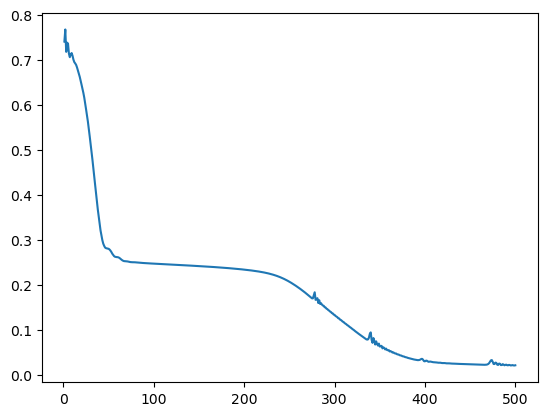

In [156]:
learn_rate = 0.001
optimizer = torch.optim.Adam(f.parameters(), lr=learn_rate)

epochs = 500
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()  # reiniciar los gradientes (poner en cero)

    y_fwd = f.forward(x)
    loss_value = torch.nn.functional.mse_loss(y_fwd, Y_data)
    # loss_value = torch.sum((y_fwd - Y_data)**2)

    loss_value.backward()  # compute gradient
    optimizer.step()    # Iterate Algorithm

    losses.append(loss_value.item())

    pass

x_ep = np.linspace(1, epochs, epochs)

sns.lineplot(x=x_ep, y=losses)

<AxesSubplot:>

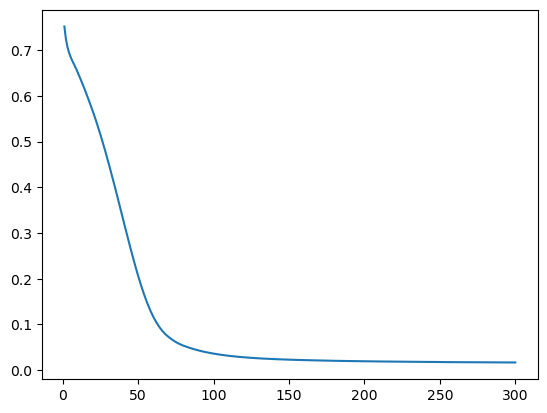

tensor(0.0210, dtype=torch.float64, grad_fn=<MseLossBackward0>)


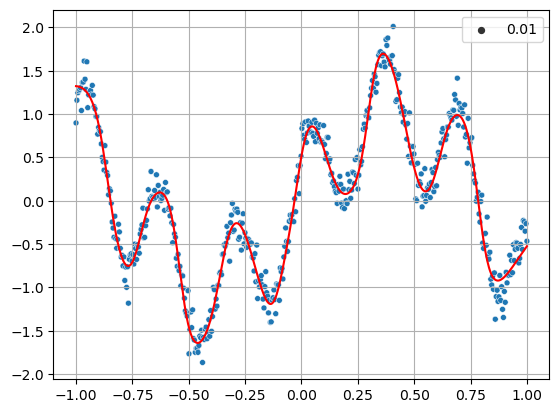

In [157]:
y = f.forward(x)

sns.scatterplot(x=x.squeeze(),y=Y_data.squeeze().detach(), size=0.01)
sns.lineplot(x=x.squeeze(), y=y.squeeze().detach(), color='red')
plt.grid(True)
loss = torch.nn.functional.mse_loss(y, Y_data)
print(loss)

In [149]:
y_fwd = f.forward(x)
loss_value = torch.nn.functional.mse_loss(y_fwd, Y_data)

print("loss:", loss_value)

loss: tensor(0.0235, dtype=torch.float64, grad_fn=<MseLossBackward0>)
